# Northwestern Mutual Interview Exercise:  Loan Default Prediction

The purpose of this exercise is to understand the current state of the loan approval process through summary statistics and exploratory data analysis (EDA). Once this is complete, modelling strategies <br> will be explored to determine if model performance is viable. Once a viable, explainable, model is found, the solution needs to be presented to stakeholders to propose a path forward. Ideally, this <br> solution will be quick to discover, as to maximize the impact of testing a viable model in production on current underwriting practices. The model is required to be explainable not only for stakeholder <br> buy-in and understanding, but to ensure that the bank is accountable for compliance laws set by regulatory authorities. A model cannot deny a person's loan application without giving them reasoning <br> on factors that influenced the decision. Lastly, there must be a tradeoff between model performance and speed. It is best if the prediction is quick in order to receive a loan decision expediently. <br> Additionally, the production model should be retrained quickly, if possible, so that it can be updated on new data as the performance degrades beyond the set tolerance level.

In [1]:
# import required packages
# general
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport

# plotting
import seaborn as sns
import squarify
import matplotlib as mpl
import matplotlib.pyplot as plt
import bokeh
import scikitplot as skplt

# modelling
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from collections import Counter

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# read in data
df = pd.read_csv("./NMLoanDefault.csv", index_col=[0])

# quick look at the data
df.head()

,PROPERTY_VALUE_AMT,TARGET,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,REASON_CDE,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,JOB_CDE,DELINGQ_CNT
0,91704.0,0,20.0,0.0,30.206893,20000,DebtCon,10.0,28440.0,0.0,143.637439,ProfExe,0.0
1,88342.0,0,11.0,0.0,43.717635,4800,HomeImp,7.0,80482.0,0.0,275.032395,ProfExe,0.0
2,242602.0,0,26.0,0.0,41.277127,25700,DebtCon,8.0,197425.0,2.0,102.960346,Other,0.0
3,68500.0,0,42.0,0.0,NaN,18000,DebtCon,10.0,45000.0,1.0,190.800000,ProfExe,0.0
4,55500.0,0,11.0,0.0,NaN,8600,DebtCon,6.0,41126.0,1.0,73.033333,Other,0.0


## Exploratory Data Analysis (EDA)

### Initial Look

In [3]:
# Check data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PROPERTY_VALUE_AMT  5848 non-null   float64
 1   TARGET              5960 non-null   int64  
 2   CRDT_LINE_CNT       5738 non-null   float64
 3   DEROG_CNT           5252 non-null   float64
 4   DEBT_INC_RTIO_AMT   4693 non-null   float64
 5   LOAN_AMT            5960 non-null   int64  
 6   REASON_CDE          5708 non-null   object 
 7   YOJ_AMT             5445 non-null   float64
 8   MORTGAGE_DUE_AMT    5442 non-null   float64
 9   RCNT_CRDT_CNT       5450 non-null   float64
 10  OLD_AGE_TRADE_AMT   5652 non-null   float64
 11  JOB_CDE             5681 non-null   object 
 12  DELINGQ_CNT         5380 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 651.9+ KB


* Target needs to be changed from int64 to object.
* Theoretically, since only the age of the oldest trade line in months and debt to income ratio have numbers past the decimal point, all other continuous variables should be able to be converted <br> to int64, since the existing decimals only have a single trailing 0. This would have to be clarified with the data type defined in the database, or any other intended range of possible values.
* In this case, it is assumed that mortgage due amount, while only having a trailing zero after the decimal, is likely to be a float rather than an integer. Property value can be assumed to be <br> rounded, as home values are not needed to be accurate to the penny.
* ***However***, this should not cause an issue for now, and to coerce from float64 to int, NA would need to be treated. The treatment strategy will depend on model performance, so NAs will be treated <br> later in order to verify the most effective method (zeros, dropping, imputation, etc.). Coercion from float64 to Int64 is possible, as NAs are tolerated in recent Pandas versions, and could be tested as well. 

In [4]:
# preserve original imported df for later plotting use
df_original = df.copy()

# coerce the target variable to an object
df = df.astype({'TARGET': 'object'})

# df = df.astype({'PROPERTY_VALUE_AMT': 'Int64', 
#                 'CRDT_LINE_CNT'     : 'Int64',
#                 'DEROG_CNT'         : 'Int64',
#                 'YOJ_AMT'           : 'Int64',
#                 'RCNT_CRDT_CNT'     : 'Int64',
#                 'DELINGQ_CNT'       : 'Int64'})

# verify change
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PROPERTY_VALUE_AMT  5848 non-null   float64
 1   TARGET              5960 non-null   object 
 2   CRDT_LINE_CNT       5738 non-null   float64
 3   DEROG_CNT           5252 non-null   float64
 4   DEBT_INC_RTIO_AMT   4693 non-null   float64
 5   LOAN_AMT            5960 non-null   int64  
 6   REASON_CDE          5708 non-null   object 
 7   YOJ_AMT             5445 non-null   float64
 8   MORTGAGE_DUE_AMT    5442 non-null   float64
 9   RCNT_CRDT_CNT       5450 non-null   float64
 10  OLD_AGE_TRADE_AMT   5652 non-null   float64
 11  JOB_CDE             5681 non-null   object 
 12  DELINGQ_CNT         5380 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 651.9+ KB


### Continuous Variables

In [5]:
# calculate summary statistics of the dataset
df.describe()

,PROPERTY_VALUE_AMT,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,DELINGQ_CNT
count,5848.000000,5738.000000,5252.000000,4693.000000,5960.000000,5445.000000,5442.000000,5450.000000,5652.000000,5380.000000
mean,101776.048741,21.296096,0.254570,33.779915,18607.969799,8.922268,73760.817200,1.186055,179.766275,0.449442
std,57385.775334,10.138933,0.846047,8.601746,11207.480417,7.573982,44457.609458,1.728675,85.810092,1.127266
min,8000.000000,0.000000,0.000000,0.524499,1100.000000,0.000000,2063.000000,0.000000,0.000000,0.000000
25%,66075.500000,15.000000,0.000000,29.140031,11100.000000,3.000000,46276.000000,0.000000,115.116702,0.000000
50%,89235.500000,20.000000,0.000000,34.818262,16300.000000,7.000000,65019.000000,1.000000,173.466667,0.000000
75%,119824.250000,26.000000,0.000000,39.003141,23300.000000,13.000000,91488.000000,2.000000,231.562278,0.000000
max,855909.000000,71.000000,10.000000,203.312149,89900.000000,41.000000,399550.000000,17.000000,1168.233561,15.000000


* Loan amount is the only variable with the same number of observations as the target variable. As noted before, an NA treatment strategy needs to be tested.
* Number of delinquent credit lines and derogatory credit are of note, as even the median value at the upper quartile is 0. Recent credit lines is similar, with a large difference <br> between the upper quartile and maximum value. The first impression would seem to indicate the the data is fairly left skewed or has strong outliers on the right side.
* Age of oldest trade lines seems suspicious. 1168 months is incredibly old for a credit account, and it is strange that an individual with an account that old would be applying for <br> a HELOC. This needs to be verified with stakeholders to ensure its accuracy. 
* Debt to income ratio is also suspicious. A maximum of 203% does not seem to be viable, unless this is current debt to income ratio rather than debt to income ratio when the person <br> applied. This may be viable if the individual lost a job prior to defaulting on the loan and the debt to income ratio was reported after defaulting. As with the age of oldest trade lines, <br> this would need to be verified with stakeholders to ensure this value is as expected.

In [6]:
# calculate the median (not susceptible to outliers whereas the mean is susceptible)
df.median()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    89235.500000
TARGET                    0.000000
CRDT_LINE_CNT            20.000000
DEROG_CNT                 0.000000
DEBT_INC_RTIO_AMT        34.818262
LOAN_AMT              16300.000000
YOJ_AMT                   7.000000
MORTGAGE_DUE_AMT      65019.000000
RCNT_CRDT_CNT             1.000000
OLD_AGE_TRADE_AMT       173.466667
DELINGQ_CNT               0.000000
dtype: float64

* Noted that the median is lower than the mean for all variables except debt to income ratio. Skewness and kurtosis is next to measure the asymmetry and shape of the distribution, respectively.

In [7]:
# calculate the skewness, or asymmetry of the distribution
df.skew()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    3.053344
TARGET                1.504317
CRDT_LINE_CNT         0.775052
DEROG_CNT             5.320870
DEBT_INC_RTIO_AMT     2.852353
LOAN_AMT              2.023781
YOJ_AMT               0.988460
MORTGAGE_DUE_AMT      1.814481
RCNT_CRDT_CNT         2.621984
OLD_AGE_TRADE_AMT     1.343412
DELINGQ_CNT           4.023150
dtype: float64

* Number of credit lines is moderately left-skewed, with all other variables strongly left-skewed.

In [8]:
# calculate the kurtosis, or shape of the distribution
df.kurtosis()

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


PROPERTY_VALUE_AMT    24.362805
TARGET                 0.263057
CRDT_LINE_CNT          1.157673
DEROG_CNT             36.872763
DEBT_INC_RTIO_AMT     50.504042
LOAN_AMT               6.932590
YOJ_AMT                0.372072
MORTGAGE_DUE_AMT       6.481866
RCNT_CRDT_CNT          9.786507
OLD_AGE_TRADE_AMT      7.599549
DELINGQ_CNT           23.565449
dtype: float64

* Years at present job and number of credit lines are the only variables that are platykurtic, which means that the distribution is flatter than the normal distribution and moderately spread out.
* All other variables are highly to extremely leptokurtic, which means that they are not very spread out, steeper, and much taller than the normal distribution. Because of the strongly positive <br> skewness, we know that we should expect a bunching of observations at the left side, tall and sharp, with a long, flat, right tail. This is also supported by the the mean being higher than the <br> median in most cases along with the maximum observation per column being much higher than the upper quartile. This will be looked for when plotting to confirm the assumption.
* No variables are mesokurtic (normally distributed). It is likely that transformation or scaling will be required to attain maximum model performance.

### Categorical Variables

In [9]:
# check categorical variables
df.describe(include = 'object')

,TARGET,REASON_CDE,JOB_CDE
count,5960,5708,5681
unique,2,2,6
top,0,DebtCon,Other
freq,4771,3928,2388


In [10]:
# check categorical variables while faceting by target
df.groupby('TARGET').describe(include = 'object')

REASON_CDE                       JOB_CDE                    
            count unique      top  freq   count unique    top  freq
TARGET                                                             
0            4567      2  DebtCon  3183    4515      6  Other  1834
1            1141      2  DebtCon   745    1166      6  Other   554

* It is noted that the top most frequent reasons and job codes are the same across both defaulted and non-defaulted loans. This will be explored further later.
* It is also noted that the minority class is about 20% of the total, and it is worth considering whether imbalanced classification treatment methods will improve model performance.
* Since the majority class can be defined as the "normal" state, it would also be worth testing a one-class anomaly detection algorithm, as they have potential to perform well in production on unseen data.

### Profile Report

In [11]:
# # create the profile report for the dateframe using pandas_profiling
# df.profile_report()
# profile = ProfileReport(df, title = "Pandas Profiling Report", explorative = True)

# # export to interactive webpage for futher exploration
# profile.to_file("explorative_profile_report.html")

#### Results
* It is immediately apparent that there are missing values in most of the columns, with some, such as debt to income ratio, being as high as ~21% missing. This will need to be explored to see how much this impacts model performance. 
* The drastic differences betweeen continuous columns such as credit line and mortgage due amount will likely require scaling or a transformation.
* [View Profile Report](explorative_profile_report.html)

### Additional Plots

Treemaps are an effective way to visualize categorical data, as long as there are not too many classes. This is my go to over barplots, as they are intuitive and quick to scan.

<AxesSubplot:>

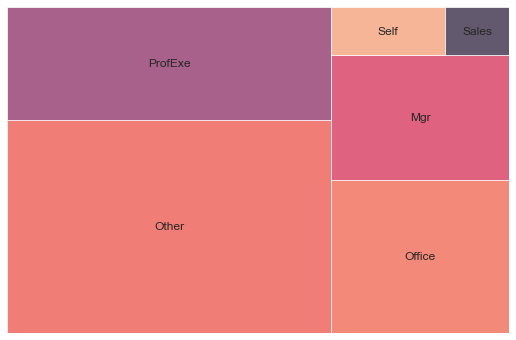

In [12]:
# set up seaborn and change matplotlib to seaborn visuals
sns.set(rc = {"figure.figsize":(9, 6)})

# treemap for the job code
plt.axis('off')
squarify.plot(sizes = pd.value_counts(df['JOB_CDE']).values, 
    label = pd.value_counts(df['JOB_CDE']).index, alpha = 0.7)

<AxesSubplot:>

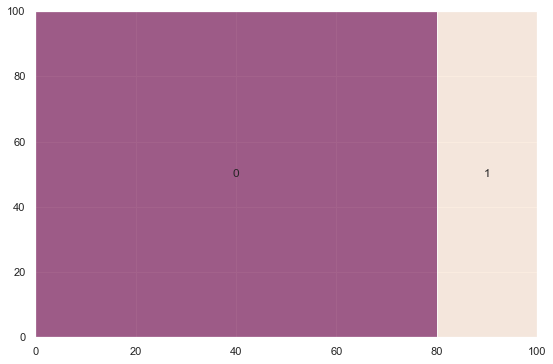

In [13]:
# treemap for loan default status
squarify.plot(sizes = pd.value_counts(df['TARGET']).values, 
    label = pd.value_counts(df['TARGET']).index, alpha = 0.7)

The target classes are slightly imbalanced at a 1:4 ratio between the minority and majority classes. This seems high that there are currently ~20% of loans defaulting, but it is likely due to the small dataset. <br> This should change when taking the full dataset into account. If not, then this needs to be followed up on with stakeholders as a sanity check that all of the data is accounted for.

<AxesSubplot:>

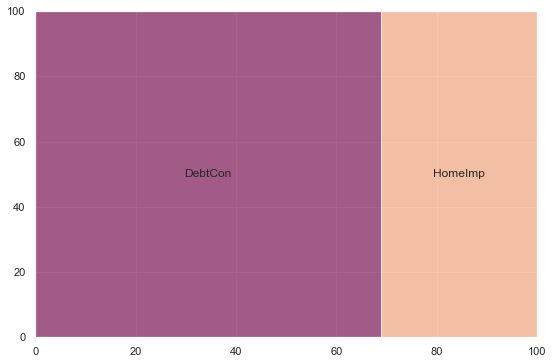

In [14]:
# treemap for loan reason code
squarify.plot(sizes = pd.value_counts(df['REASON_CDE']).values, 
    label = pd.value_counts(df['REASON_CDE']).index, alpha = 0.7)

Violin plots are an efective way to view distribution of data. Unlike histograms, they are not influenced by how many buckets are chosen and show outliers easily. <br> This allows for rapid comparison of each variable faceted by each class for a basic understanding of the differences between loan payoffs and loan defaults.

<AxesSubplot:xlabel='TARGET', ylabel='JOB_CDE'>

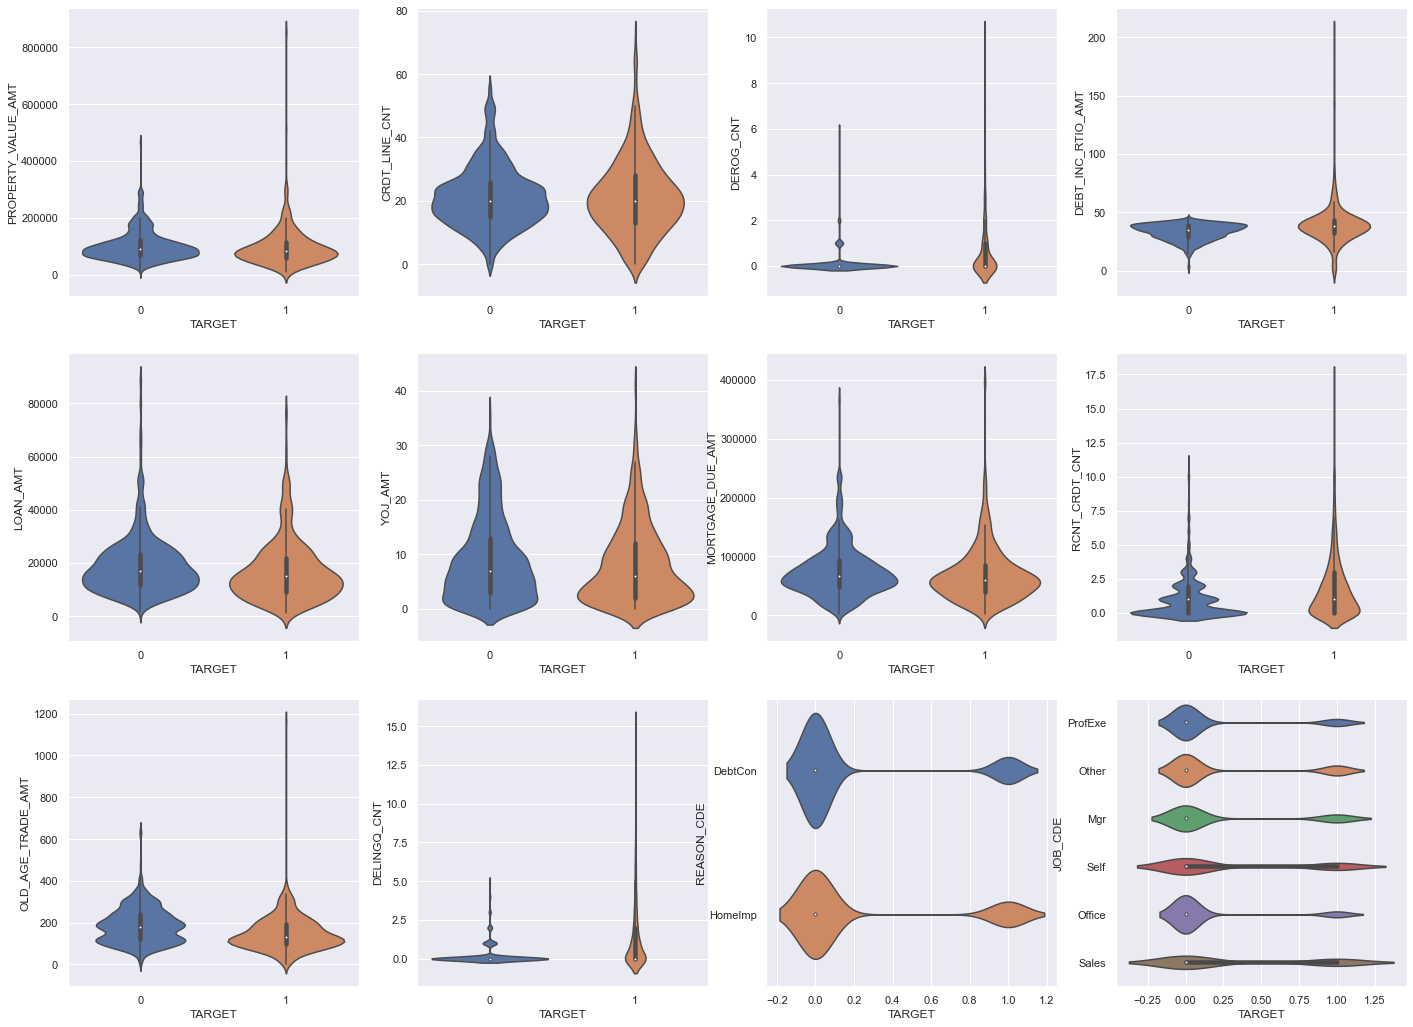

In [15]:
# set up plot
sns.set(rc = {"figure.figsize":(24, 18)})
fig, axes = plt.subplots(3, 4)

# creating each plot for the subplots
## note--seaborn violin plots will not take a categorical variable in the x argument, only in the y argument
sns.violinplot(data = df_original, x = 'TARGET', y = 'PROPERTY_VALUE_AMT', ax = axes [0, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'CRDT_LINE_CNT',      ax = axes [0, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DEROG_CNT',          ax = axes [0, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DEBT_INC_RTIO_AMT',  ax = axes [0, 3])
sns.violinplot(data = df_original, x = 'TARGET', y = 'LOAN_AMT',           ax = axes [1, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'YOJ_AMT',            ax = axes [1, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'MORTGAGE_DUE_AMT',   ax = axes [1, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'RCNT_CRDT_CNT',      ax = axes [1, 3])
sns.violinplot(data = df_original, x = 'TARGET', y = 'OLD_AGE_TRADE_AMT',  ax = axes [2, 0])
sns.violinplot(data = df_original, x = 'TARGET', y = 'DELINGQ_CNT',        ax = axes [2, 1])
sns.violinplot(data = df_original, x = 'TARGET', y = 'REASON_CDE',         ax = axes [2, 2])
sns.violinplot(data = df_original, x = 'TARGET', y = 'JOB_CDE',            ax = axes [2, 3])

Based on the violin plots, my hypothesis is that age of oldest trade line, number of delinquent credit lines, and number of derogatory reports will have significant importance in the model.

## Modeling

Scikit-learn is widely used in the industry, and will be used as a quick start. However, it is also being used to show that training several models can be time consuming, and model selection can take <br> time to find an appropriate model. After this, AutoGluon will be examined for rapid testing of many models.

### Setup

An imputation strategy is needed to deal with the NA values. While some models take care of them automatically, we are limiting the range of possible models to test if this is not taken care of.

In [16]:
# impute columns with the median value
def impute_col(df, col, imp_type='median'):
    imp_median = SimpleImputer(missing_values = np.nan, strategy = imp_type)
    df[col] = imp_median.fit_transform(np.array(df[col]).reshape(-1, 1))

In [17]:
# change from text labels to coded categories
df['REASON_CDE'] = df['REASON_CDE'].astype('category').cat.codes
df['JOB_CDE'] = df['JOB_CDE'].astype('category').cat.codes

In [18]:
# set continuous columns to be imputed
impute_cols = ['PROPERTY_VALUE_AMT', 'CRDT_LINE_CNT', 'DEROG_CNT',
       'DEBT_INC_RTIO_AMT', 'LOAN_AMT', 'YOJ_AMT',
       'MORTGAGE_DUE_AMT', 'RCNT_CRDT_CNT', 'OLD_AGE_TRADE_AMT',
       'DELINGQ_CNT']

# impute missing values of continuous columns using the nearest neighbor
imputer = KNNImputer(n_neighbors = 3)
df[impute_cols] = imputer.fit_transform(df[impute_cols])

# scale values to minimize effect of outliers on model performance
for col in impute_cols:
    min_max_scaler = MinMaxScaler()
    df[col] = min_max_scaler.fit_transform(np.array(df[col]).reshape(-1, 1))

In [19]:
# impute missing values in categorical columns using the most frequent label
for col in ['JOB_CDE', 'REASON_CDE']:
    impute_col(df, col, 'most_frequent')

In [20]:
# map variables to prep for survival algorithms
df['TARGET'] = df['TARGET'].map({0: 1, 1: -1})

In [21]:
# prep X
df_copy = df.copy()
labels = df['TARGET']
data = df_copy.drop(columns=['TARGET'])

In [22]:
# prep y
y = labels.to_numpy()

In [23]:
X = df.to_numpy()
X = np.asarray(X, dtype='float64')

### TSNE

TSNE is being used as a rough visualization to see if the target classes are separable. 

C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
C:\Users\Jeremy\.conda\envs\ds4b_101p\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


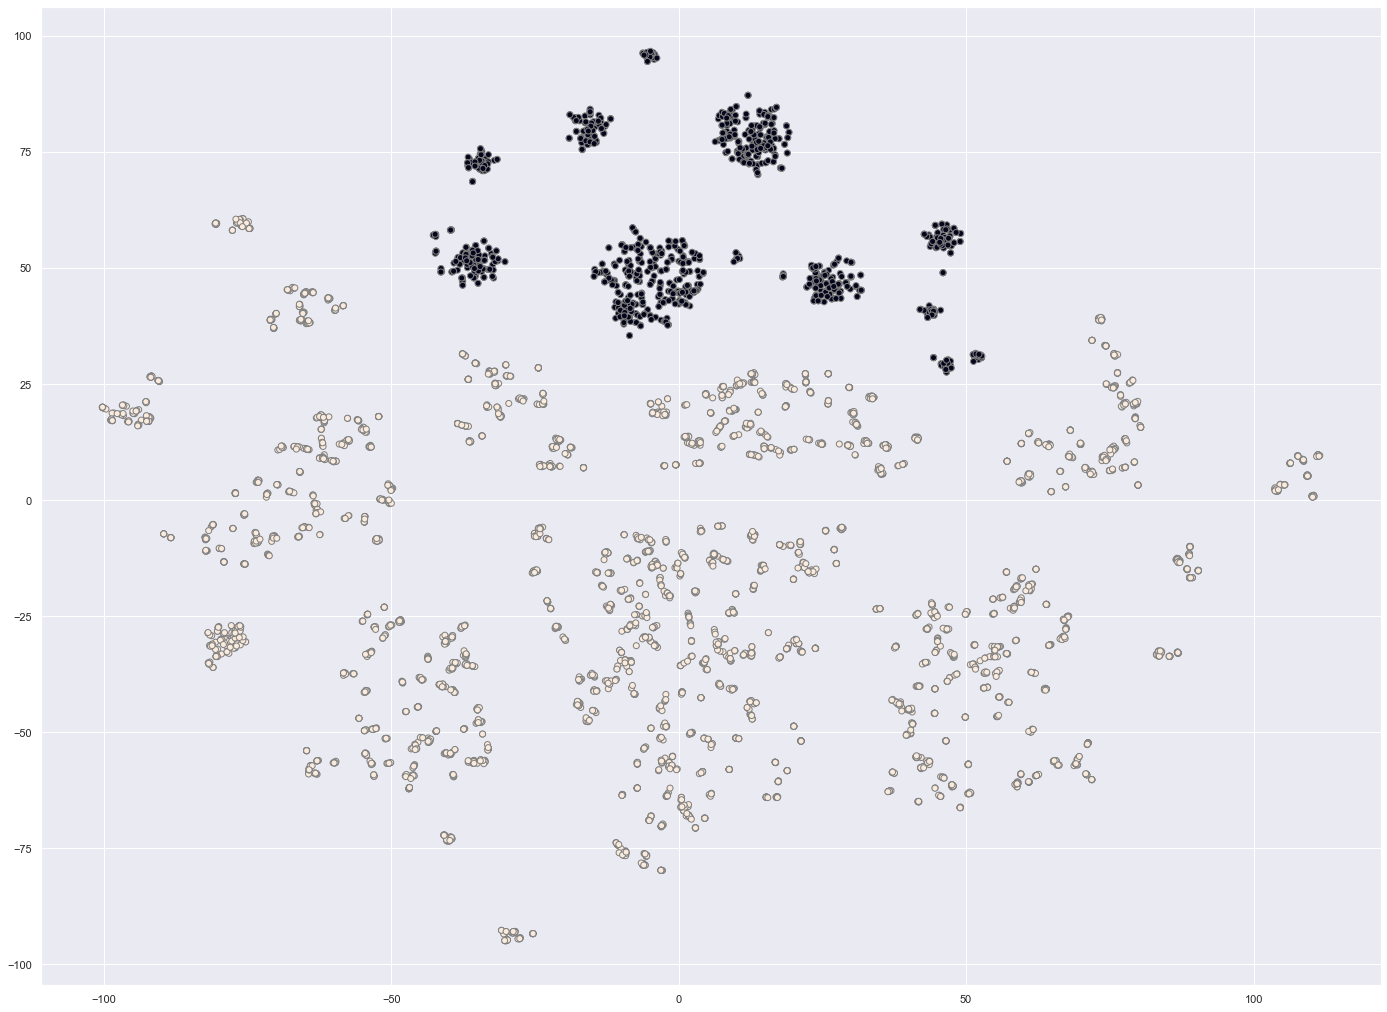

In [24]:
# T-distributed Stochastic Neighbor Embedding to model relationship
X_embedded = TSNE(n_components = 2, init = 'pca').fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, edgecolor = 'grey')

Sanity check to see if the target classes are separable before testing survival algorithms. 

### KernelPCA

As with TSNE, KernelPCA is also being used to visualize the separability of the classes. The kernel and gamma were chosen based on separability, although no significant overlap was found with other hyperparameters. <br> 
KernelPCA can be used to decrease the dimensionality of the dataset, but it sensitive to outliers, so it will not be used beyond checking for sebarability.

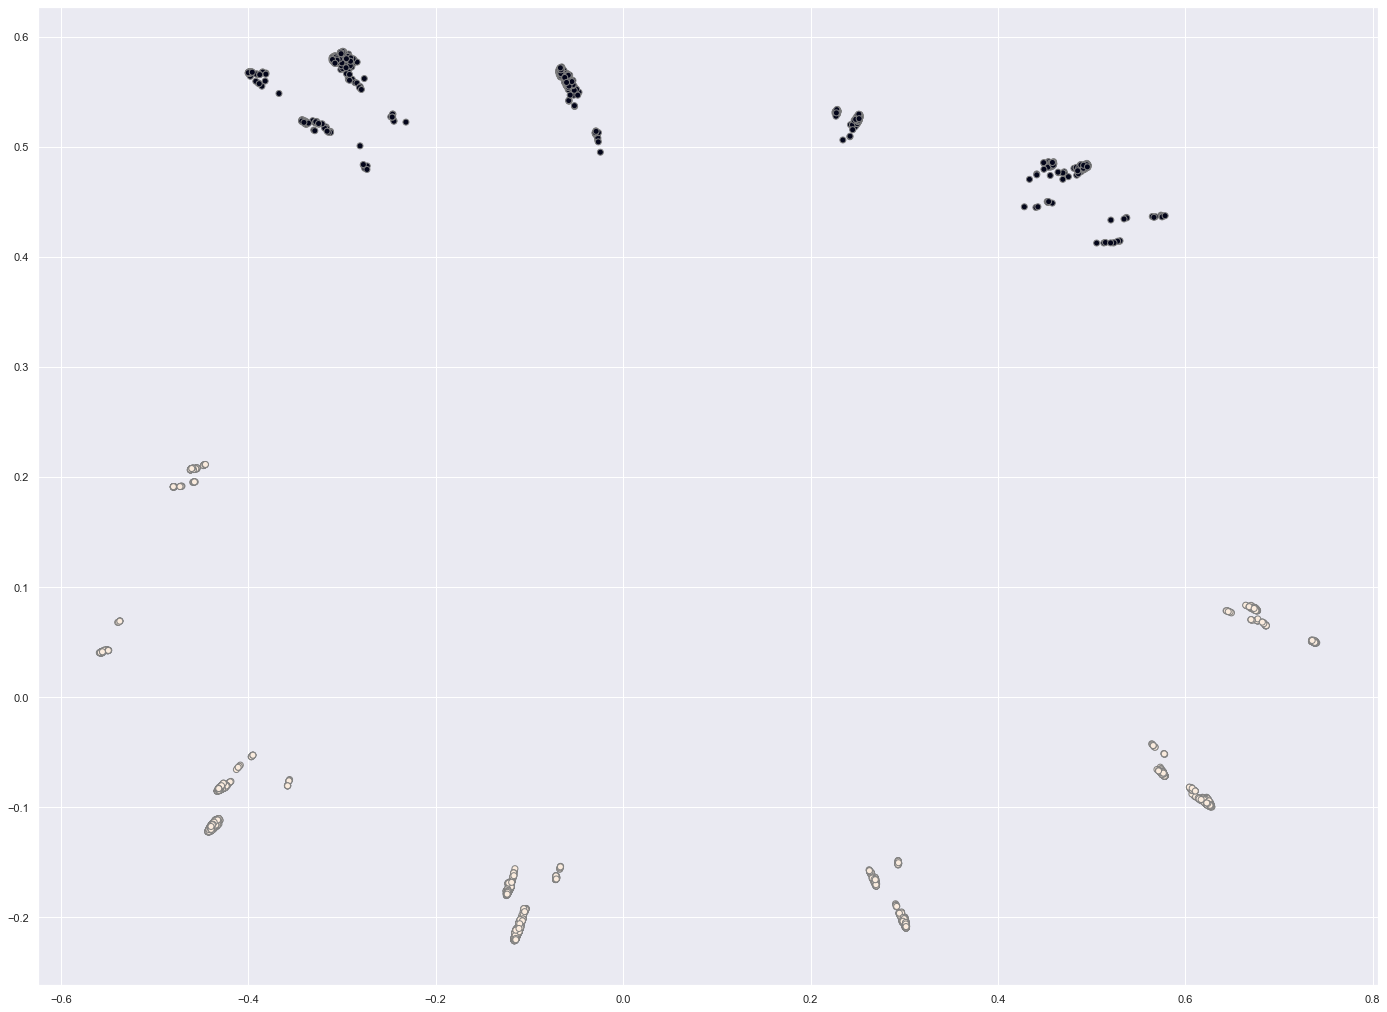

In [25]:
transformer = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 0.1)
X_embedded = transformer.fit_transform(X)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c = y, edgecolor = 'grey')

Another sanity check to see if target classes are separable. 

### Train/Test Split

In [26]:
# 66/33 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train_oc = X_train[y_train == 1]
y_train_oc = y_train[y_train == 1]

### One Class SVM

One-class SVMs are resistant to outliers and perform well in many imbalanced classification applications, and have potential to outperform random forest models. Here is [an example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2492881/). <br> 
However, they typically take longer to train than random forests due to their complexity. As such, they take far longer to train on large datasets. Regardless, treating this problem as outlier detection, especially since TSNE showed that the <br>
classes are separable, can have great potential. Additionally, one-class SVMs tend to be resistant to outliers in real-world unseen data, and can perform well in production.

In [28]:
# train the single class SVM with manually tested hyperparameters
clf = OneClassSVM(gamma = 0.7, nu = 0.01).fit(X_train_oc)

Hyperparameters were tuned manually to find the best F1 score. This only took a quick minute.

In [29]:
# predict 
y_pred = clf.predict(X_test)

In [30]:
f1_score(y_pred, y_test)

0.9929802169751117

In [31]:
Counter(y_pred)

Counter({1: 1556, -1: 411})

In [32]:
"""
nus = np.linspace(0.001,1,100)
gammas = np.linspace(0.001,1,100)
tuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}

clf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=5,
                           scoring=f1_score, return_train_score=True)
clf.fit(X_train, y_train)
"""

"\nnus = np.linspace(0.001,1,100)\ngammas = np.linspace(0.001,1,100)\ntuned_parameters = {'kernel' : ['rbf'], 'gamma' : gammas, 'nu': nus}\n\nclf = GridSearchCV(OneClassSVM(), tuned_parameters, cv=5,\n                           scoring=f1_score, return_train_score=True)\nclf.fit(X_train, y_train)\n"

Grid search to determine the best hyperparameters to choose was originally considered, but it took a short time to edit the hypermarameters such that the result was highly satisfactory.

### Isolation forest 

Testing another outlier detection method to see how the performance stacks against the one-class SVM.

In [33]:
clf = IsolationForest(random_state = 42).fit(X_train_oc)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
f1_score(y_pred, y_test)

0.8734216199568832

### Random Forest

Testing random forest due to their traditionally strong performance on problems of this class.

In [36]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
f1_score(y_pred, y_test)

1.0

### AutoGluon

While scikit-learn is well-used throughout the industry, the emergence of high-quality auto-ml packages allows for a massive increase in the ability to scale efficiency of model testing. Once several viable models have been evaluated, it is possible The optimal metric to use would most likely have been precision-recall curve, as discussed [in this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/), but AutoGluon does not have this built in. Therefore, AUC_ROC will be used as the optimization metric. AutoGluon does have the option to add a custom metric to AutoGluon, but it was not explored in this application. For extensive testing, the custom option would be explored. AUC_ROC was chosen because it is more resilient to class imbalances than F1, especially with F1 not accounting for True Negatives.

#### Setup

In [39]:
# verify torch installation
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.4174, 0.7329, 0.1934],
        [0.5156, 0.5930, 0.0514],
        [0.7303, 0.7115, 0.6486],
        [0.8511, 0.6712, 0.5737],
        [0.1066, 0.3134, 0.9823]])


In [40]:
# verify cuda
torch.cuda.is_available()

True

In [41]:
# verify device count
torch.cuda.device_count()

1

In [42]:
df_original_copy = df_original.copy()
df_original_copy = df_original_copy.astype({'TARGET': 'object'})
df_original_copy[impute_cols] = imputer.fit_transform(df_original_copy[impute_cols])
for col in ['JOB_CDE', 'REASON_CDE']:
    impute_col(df_original_copy, col, 'most_frequent')

In [43]:
train = df_original_copy.sample(frac = 0.8, random_state = 42)
test = df_original_copy.drop(train.index)

In [44]:
train_data = TabularDataset(train)
train_data.head()

,PROPERTY_VALUE_AMT,TARGET,CRDT_LINE_CNT,DEROG_CNT,DEBT_INC_RTIO_AMT,LOAN_AMT,REASON_CDE,YOJ_AMT,MORTGAGE_DUE_AMT,RCNT_CRDT_CNT,OLD_AGE_TRADE_AMT,JOB_CDE,DELINGQ_CNT
1344,186118.0,0,39.0,0.333333,32.875126,28500.0,DebtCon,1.0,137174.0,2.333333,115.294811,Mgr,0.000000
625,135700.0,0,16.0,1.000000,27.702364,15000.0,DebtCon,3.0,95300.0,3.000000,115.666667,Office,0.333333
5908,156000.0,0,43.0,0.000000,30.513930,10000.0,HomeImp,5.0,131589.0,1.000000,419.033333,ProfExe,1.000000
2991,266430.0,0,50.0,0.000000,35.871959,24000.0,HomeImp,7.0,239568.0,3.000000,243.732417,Self,0.000000
1545,68759.0,1,19.0,0.000000,31.353907,9500.0,HomeImp,9.0,54612.0,0.000000,89.102839,Other,0.000000


In [45]:
label = 'TARGET'
print(f"Summary of class variable '{label}': \n", train_data[label].describe())

Summary of class variable 'TARGET': 
 count     4768
unique       2
top          0
freq      3824
Name: TARGET, dtype: int64


In [46]:
test_data = TabularDataset(test)
y_test = test_data[label]

#### Medium Quality

Testing medium quality first, as specified in the AutoGluon documentation, for a rapid test of all models. Here we are sacrificing model performance to minimize training time and receive initial results.

In [47]:
# set metrics
save_path = 'defaultModels-predictTarget'
metric = 'roc_auc'

## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'medium_quality')
# predictor.leaderboard(test_data, silent=True)

In [48]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget")
predictor.leaderboard(test_data, silent = True).sort_values('score_val', ascending = False)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
1,WeightedEnsemble_L2,0.969153,0.968236,0.637594,0.121962,5.006038,0.007002,0.001000,0.899000,2,True,14
0,ExtraTreesEntr,0.969371,0.967443,0.237091,0.108962,0.521068,0.237091,0.108962,0.521068,1,True,9
2,ExtraTreesGini,0.968864,0.964445,0.170289,0.124527,0.517765,0.170289,0.124527,0.517765,1,True,8
3,RandomForestEntr,0.948010,0.941409,0.134999,0.125000,0.620498,0.134999,0.125000,0.620498,1,True,6
4,RandomForestGini,0.945805,0.938260,0.139500,0.125194,0.508499,0.139500,0.125194,0.508499,1,True,5
5,LightGBMXT,0.938978,0.923499,0.041001,0.009000,1.581970,0.041001,0.009000,1.581970,1,True,3
6,CatBoost,0.930552,0.922189,0.024484,0.003499,45.659553,0.024484,0.003499,45.659553,1,True,7
8,LightGBM,0.923483,0.902869,0.601497,0.005000,0.409000,0.601497,0.005000,0.409000,1,True,4
7,LightGBMLarge,0.923889,0.901131,0.014499,0.004500,1.472999,0.014499,0.004500,1.472999,1,True,13
10,NeuralNetFastAI,0.899690,0.897504,0.393501,0.012000,3.585970,0.393501,0.012000,3.585970,1,True,10


##### Results
* Metric: ROC_AUC
* AutoGluon training complete, total runtime = 83.3s ... Best model: "WeightedEnsemble_L2" with 0.968236
* Second-best: "ExtraTreesEntr" with 0.967443
* Third-best: "Extra TreesGini" with 0.964445

In [49]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.956806,0.043194
4,0.835082,0.164918
5,0.972162,0.027838
9,0.799664,0.200336
16,0.970873,0.029127
34,0.858798,0.141202
54,0.801204,0.198796
55,0.987616,0.012384
64,0.993689,0.006311
66,0.339874,0.660126


In [50]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)
print("Performance:  \n", perf)

Performance:  
 {'roc_auc': 0.9691528564963472, 'accuracy': 0.9035234899328859, 'balanced_accuracy': 0.7758959550029093, 'mcc': 0.6841817305101187, 'f1': 0.7043701799485862, 'precision': 0.9513888888888888, 'recall': 0.5591836734693878}


In [51]:
predictor.get_model_best()

'WeightedEnsemble_L2'

In [52]:
predictor.feature_importance(test_data)

,importance,stddev,p_value,n,p99_high,p99_low
DELINGQ_CNT,0.099776,0.013248,0.002913,3,0.175691,0.023861
OLD_AGE_TRADE_AMT,0.073773,0.013187,0.005241,3,0.149334,-0.001788
RCNT_CRDT_CNT,0.052316,0.004991,0.001510,3,0.080914,0.023719
CRDT_LINE_CNT,0.044392,0.001245,0.000131,3,0.051526,0.037257
REASON_CDE,0.041514,0.005691,0.003103,3,0.074126,0.008902
JOB_CDE,0.039203,0.005271,0.002986,3,0.069405,0.009001
DEROG_CNT,0.036653,0.007625,0.007060,3,0.080343,-0.007036
YOJ_AMT,0.035006,0.001259,0.000216,3,0.042221,0.027790
PROPERTY_VALUE_AMT,0.034387,0.004237,0.002511,3,0.058665,0.010109
MORTGAGE_DUE_AMT,0.029815,0.005413,0.005405,3,0.060834,-0.001204


#### Best Quality - 30-minute limit

Now that the baseline has been seen, increase the training quality and time limit to see if there is a large difference in model performance.

In [71]:
# set parameters with time limit of 30-minutes
time_limit = 1800
save_path = 'defaultModels-predictTarget-bestQuality'

# increase quality level now that the baseline tests have been run (noted later that this maxes out at ~16-17 minutes)
## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'best_quality')
# predictor.leaderboard(test_data, silent=True)

In [54]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget-bestQuality")
predictor.leaderboard(test_data, silent=True).sort_values('score_val', ascending = False)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
1,WeightedEnsemble_L3,0.986212,0.984910,2.265197,1.774289,792.548261,0.002000,0.001500,1.507028,3,True,26
5,LightGBMXT_BAG_L2,0.984574,0.983947,1.813197,1.453785,699.593735,0.053001,0.033003,3.145993,2,True,15
3,CatBoost_BAG_L2,0.984984,0.983342,1.779197,1.443880,855.969234,0.019001,0.023097,159.521493,2,True,19
6,LightGBM_BAG_L2,0.983699,0.982299,1.797195,1.447288,699.738240,0.036999,0.026505,3.290498,2,True,16
4,XGBoost_BAG_L2,0.984880,0.981341,1.833695,1.474782,700.616739,0.073499,0.053999,4.168998,2,True,23
0,NeuralNetFastAI_BAG_L2,0.986691,0.980893,1.956196,1.553778,722.048245,0.196000,0.132996,25.600504,2,True,22
2,NeuralNetTorch_BAG_L2,0.985423,0.980251,1.977197,1.580285,759.004237,0.217001,0.159503,62.556496,2,True,24
8,RandomForestEntr_BAG_L2,0.980404,0.980052,1.887196,1.579782,697.061705,0.127000,0.159000,0.613963,2,True,18
7,ExtraTreesEntr_BAG_L2,0.980592,0.979167,1.882695,1.584782,696.859698,0.122499,0.163999,0.411957,2,True,21
9,ExtraTreesGini_BAG_L2,0.979738,0.978349,1.883024,1.589812,696.859747,0.122828,0.169030,0.412006,2,True,20


##### Results
* Metric: ROC_AUC
* AutoGluon training complete, total runtime = 973.1s... Best model: "WeightedEnsemble_L3" with 0.984910
* Second-best: "LightGBMXT_BAG_L2" with 0.983947
* Third-best: "CatBoost_BAG_L2" with 0.983342

In [55]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.998264,0.001735
4,0.983415,0.016585
5,0.997052,0.002948
9,0.996465,0.003535
16,0.997095,0.002905
34,0.951111,0.048889
54,0.941364,0.058636
55,0.998119,0.001881
64,0.997489,0.002511
66,0.011233,0.988767


In [56]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)
print("Performance:  \n", perf)

Evaluation: roc_auc on test data: 0.9862120983557097
Evaluations on test data:
{
    "roc_auc": 0.9862120983557097,
    "accuracy": 0.959731543624161,
    "balanced_accuracy": 0.9353231472103096,
    "mcc": 0.875993750568675,
    "f1": 0.9012345679012346,
    "precision": 0.9087136929460581,
    "recall": 0.8938775510204081
}


Performance:  
 {'roc_auc': 0.9862120983557097, 'accuracy': 0.959731543624161, 'balanced_accuracy': 0.9353231472103096, 'mcc': 0.875993750568675, 'f1': 0.9012345679012346, 'precision': 0.9087136929460581, 'recall': 0.8938775510204081}


In [57]:
predictor.get_model_best()

'WeightedEnsemble_L3'

In [58]:
predictor.feature_importance(test_data)

Computing feature importance via permutation shuffling for 12 features using 1000 rows with 3 shuffle sets...
	84.91s	= Expected runtime (28.3s per shuffle set)
	30.01s	= Actual runtime (Completed 3 of 3 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
DELINGQ_CNT,0.071054,0.007800,0.001996,3,0.115748,0.026360
OLD_AGE_TRADE_AMT,0.064146,0.011070,0.004891,3,0.127579,0.000712
RCNT_CRDT_CNT,0.041553,0.004046,0.001573,3,0.064739,0.018368
CRDT_LINE_CNT,0.037115,0.002775,0.000929,3,0.053017,0.021212
JOB_CDE,0.035104,0.004163,0.002328,3,0.058958,0.011250
REASON_CDE,0.033902,0.005034,0.003635,3,0.062748,0.005055
YOJ_AMT,0.032389,0.000766,0.000093,3,0.036776,0.028003
PROPERTY_VALUE_AMT,0.028917,0.002195,0.000957,3,0.041494,0.016340
MORTGAGE_DUE_AMT,0.026142,0.001697,0.000701,3,0.035866,0.016419
DEROG_CNT,0.024999,0.005288,0.007295,3,0.055301,-0.005302


#### Best Quality -  7-hour limit

This model was trained overnight to see if any improvement could be made over the 30-minute training time limit.

In [70]:
# set parameters with time limit of 7-hours
time_limit = 25200
save_path = 'defaultModels-predictTarget-bestQuality-7Hours'

# run again at maximum quality for a longer maximum allowed time frame (noted later that this maxes out at ~16-17 minutes)
## commented out the training after model was exported
# predictor = TabularPredictor(label = label, path = save_path, eval_metric = metric).fit(train_data, presets = 'best_quality')
# predictor.leaderboard(test_data, silent=True)

In [61]:
# load saved model and bypass the training time
predictor = TabularPredictor.load("defaultModels-predictTarget-bestQuality-7Hours")
predictor.leaderboard(test_data, silent=True).sort_values('score_val', ascending = False)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
1,WeightedEnsemble_L3,0.986212,0.984910,2.488218,1.825728,804.058715,0.002531,0.001998,1.623529,3,True,26
5,LightGBMXT_BAG_L2,0.984574,0.983947,1.959687,1.495740,704.096685,0.065500,0.030502,3.059998,2,True,15
3,CatBoost_BAG_L2,0.984984,0.983342,1.913687,1.489122,856.428721,0.019500,0.023885,155.392034,2,True,19
6,LightGBM_BAG_L2,0.983699,0.982299,1.939687,1.493735,704.496686,0.045500,0.028497,3.459999,2,True,16
4,XGBoost_BAG_L2,0.984880,0.981341,1.984654,1.529738,705.150184,0.090467,0.064500,4.113496,2,True,23
0,NeuralNetFastAI_BAG_L2,0.986691,0.980893,2.132188,1.598234,727.241192,0.238001,0.132996,26.204505,2,True,22
2,NeuralNetTorch_BAG_L2,0.985423,0.980251,2.136686,1.631735,769.710685,0.242500,0.166497,68.673997,2,True,24
8,RandomForestEntr_BAG_L2,0.980404,0.980052,2.021188,1.621767,701.666890,0.127001,0.156529,0.630202,2,True,18
7,ExtraTreesEntr_BAG_L2,0.980592,0.979167,2.019688,1.639267,701.446531,0.125501,0.174030,0.409843,2,True,21
9,ExtraTreesGini_BAG_L2,0.979738,0.978349,2.032717,1.635625,701.449556,0.138530,0.170387,0.412868,2,True,20


##### Results
* Metric: ROC_AUC
* AutoGluon training complete, total runtime = 982.61s ... Best model: "WeightedEnsemble_L3" with 0.984910
* Second-best: "LightGBMXT_BAG_L2" with 0.983947
* Third-best: "CatBoost_BAG_L2" with 0.983342	
* Note: Already maximized training time, results are identical to the 30-minute test. Training time is consistently less than 17 minutes during repeated tests.

In [62]:
# predict with trained model and compare to the test set
pred_probs = predictor.predict_proba(test_data)
pred_probs.head(10)

,0,1
3,0.998264,0.001735
4,0.983415,0.016585
5,0.997052,0.002948
9,0.996465,0.003535
16,0.997095,0.002905
34,0.951111,0.048889
54,0.941364,0.058636
55,0.998119,0.001881
64,0.997489,0.002511
66,0.011233,0.988767


In [63]:
# get in-depth metrics on model performance
y_pred = predictor.predict_proba(test_data)
perf = predictor.evaluate_predictions(y_true = y_test, y_pred = y_pred, auxiliary_metrics = True)
print("Performance:  \n", perf)

Evaluation: roc_auc on test data: 0.9862120983557097
Evaluations on test data:
{
    "roc_auc": 0.9862120983557097,
    "accuracy": 0.959731543624161,
    "balanced_accuracy": 0.9353231472103096,
    "mcc": 0.875993750568675,
    "f1": 0.9012345679012346,
    "precision": 0.9087136929460581,
    "recall": 0.8938775510204081
}


Performance:  
 {'roc_auc': 0.9862120983557097, 'accuracy': 0.959731543624161, 'balanced_accuracy': 0.9353231472103096, 'mcc': 0.875993750568675, 'f1': 0.9012345679012346, 'precision': 0.9087136929460581, 'recall': 0.8938775510204081}


In [65]:
predictor.get_model_best()

'WeightedEnsemble_L3'

In [73]:
perm_imp = predictor.feature_importance(test_data)
perm_imp

,importance,stddev,p_value,n,p99_high,p99_low
DELINGQ_CNT,0.071054,0.007800,0.001996,3,0.115748,0.026360
OLD_AGE_TRADE_AMT,0.064146,0.011070,0.004891,3,0.127579,0.000712
RCNT_CRDT_CNT,0.041553,0.004046,0.001573,3,0.064739,0.018368
CRDT_LINE_CNT,0.037115,0.002775,0.000929,3,0.053017,0.021212
JOB_CDE,0.035104,0.004163,0.002328,3,0.058958,0.011250
REASON_CDE,0.033902,0.005034,0.003635,3,0.062748,0.005055
YOJ_AMT,0.032389,0.000766,0.000093,3,0.036776,0.028003
PROPERTY_VALUE_AMT,0.028917,0.002195,0.000957,3,0.041494,0.016340
MORTGAGE_DUE_AMT,0.026142,0.001697,0.000701,3,0.035866,0.016419
DEROG_CNT,0.024999,0.005288,0.007295,3,0.055301,-0.005302


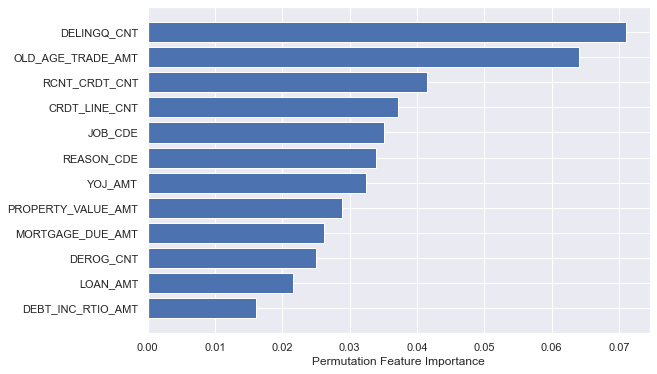

In [84]:
# plot feature importance
sort = perm_imp.sort_values('importance', ascending = True)
plt.barh(sort.index, sort.importance)
plt.xlabel("Permutation Feature Importance")
plt.show()

##### Feature Importance
The most important features remain the same as the medium-quality test. However, delinquent credit lines dropped in importance from the initial run to the 7-hour, best-quality run. It is quite interesting that the number of derogatory reports dropped in its ranking by several positions. It is good to keep in mind that the feature importance is possible that it is being affected by the large outliers in debt to income ratio (200%) and age of oldest trade line (1100 months). However, since the min max scaler was applied, the data should be normalized and decrease the effect on the model training. Further steps to take would be to test a transformation such as log or box cox and compare any changes in variable importance. As mentioned before, extreme outliers such as this should be addressed with stakeholders as a sanity check. Additional data may also affect this positively by increasing the number of real-world cases and decreasing the effect of extreme edge cases.

Interestingly, number of delinquent credit lines and age of oldest trade line had the highest feature importance, as was suspected. However, number of derogatory reports had lower feature importance than was originally expected. Number of recent credit lines had the third-highest feature importance, and was not originally expected to be that high.

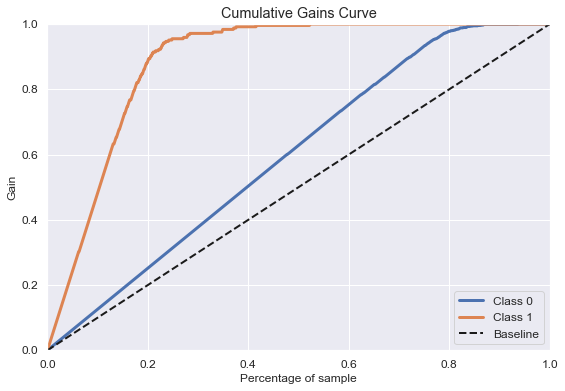

In [64]:
# set up seaborn and change matplotlib to seaborn visuals
sns.set(rc = {"figure.figsize":(9, 6)})

# plot the cumulative gains of the model to compare to baseline performance
skplt.metrics.plot_cumulative_gain(y_test, pred_probs)
plt.show()

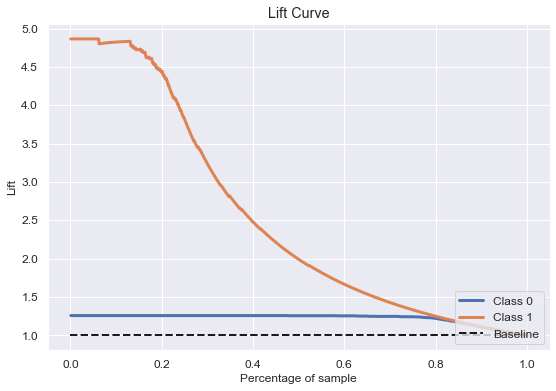

In [68]:
# plot the lift cumulative gains of the model to compare to baseline performance
skplt.metrics.plot_lift_curve(y_test, pred_probs)
plt.show()

## Conclusion